In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Approach 
 
    
##### Reason to use Python over R:
    Text handling capabilities in Python are much advance and have low learning curve thus python is chosen as first language to process data. 
    
So in this excercise we will be using Following libraries:
* Numpy
* Python Pandas 
* ScikitLearn

##### import libraries

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [3]:
# Variable name
col_names_dtype = pd.read_table('kddcup.names', header=None, skiprows=1, delimiter=':', names=['variable','data_type']  )
col_names_dtype.head()

,variable,data_type
0,duration,continuous.
1,protocol_type,symbolic.
2,service,symbolic.
3,flag,symbolic.
4,src_bytes,continuous.


In [4]:
variables = list(col_names_dtype.variable)
variables.append('attack')
print(variables)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack']


##### Load train data

In [5]:
train_data = pd.read_table("kddcup.data.gz",compression='gzip',sep=',', names = variables)

In [6]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
# What is the dimention of dataframe?
train_data.shape

(4898431, 42)

In [8]:
# What is the distribution of target class?
train_data.attack = train_data.attack.str.replace(".","")
train_data.attack.value_counts().head(10)

smurf          2807886
neptune        1072017
normal          972781
satan            15892
ipsweep          12481
portsweep        10413
nmap              2316
back              2203
warezclient       1020
teardrop           979
Name: attack, dtype: int64

##### Loading Test data

In [9]:
test_data = pd.read_table("data/corrected.gz",compression='gzip',sep=',', names = variables)
test_data.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal.


In [10]:
test_data.shape

(311029, 42)

In [11]:
# What is the distribution of target class?
test_data.attack = test_data.attack.str.replace(".","")
test_data.attack.value_counts().head(10)

smurf            164091
normal            60593
neptune           58001
snmpgetattack      7741
mailbomb           5000
guess_passwd       4367
snmpguess          2406
satan              1633
warezmaster        1602
back               1098
Name: attack, dtype: int64

## Task 2 - Create suspicious column

### Feature Engineering

In [12]:
# Adding Suspecious Variable 
train_data['suspicious'] = 0.0
test_data['suspicious'] = 0.0

In [13]:
# there is no ftp in protocol_type. Look for other features where i can find this information of protocol type
test_data.protocol_type.unique()

array(['udp', 'tcp', 'icmp'], dtype=object)

#### Scenario 1
1. if protocol_type == tcp    &
2. if num_failed_logins >2   &
3. if dst_bytes >0


then call those connections as suspecious

In [14]:
index_to_change = train_data[(train_data.protocol_type == 'tcp') & 
                             (train_data.num_failed_logins >2) & 
                             (train_data.dst_bytes > 0)].index
index_to_change
train_data.loc[index_to_change,'suspicious'] = 1.0

# train_data[(train_data.protocol_type == 'tcp') & 
#            (train_data.num_failed_logins >2) & 
#            (train_data.dst_bytes > 0)].suspicious

156965     1.0
157053     1.0
406543     1.0
421189     1.0
741454     1.0
761733     1.0
1381942    1.0
1419769    1.0
1446988    1.0
Name: suspicious, dtype: float64

In [15]:
index_to_change = test_data[(test_data.protocol_type == 'tcp') & 
                            (test_data.num_failed_logins >2) & 
                            (test_data.dst_bytes > 0)].index
index_to_change
test_data.loc[index_to_change,'suspicious'] = 1.0

# test_data[(test_data.protocol_type == 'tcp') & 
#           (test_data.num_failed_logins >2) & 
#           (test_data.dst_bytes > 0)].suspicious

#### Scenario 2
1. if service is like 'ftp'    &
2. if num_failed_logins >2   &
3. if dst_bytes >0


then call those connections as suspecious

In [18]:
# in service there is 
train_data[train_data.service.str.contains('ftp')].service.value_counts()

ftp_data    40697
ftp          5214
tftp_u          3
Name: service, dtype: int64

In [19]:
# in service there is 
test_data[test_data.service.str.contains('ftp')].service.value_counts()

ftp_data    2223
ftp          837
tftp_u         1
Name: service, dtype: int64

##### Code to Apply change ---Not used

index_to_change = train_data[(train_data.service.str.contains('ftp')) & 
                             (train_data.num_failed_logins >2) & 
                             (train_data.dst_bytes > 0)].index
index_to_change
train_data.loc[index_to_change,'suspicious'] = 1.0

train_data[(train_data.protocol_type == 'tcp') & 
           (train_data.num_failed_logins >2) & 
           (train_data.dst_bytes > 0)].suspicious

index_to_change = test_data[(test_data.service.str.contains('ftp')) & 
                            (test_data.num_failed_logins >2) & 
                            (test_data.dst_bytes > 0)].index
index_to_change
test_data.loc[index_to_change,'suspicious'] = 1.0
test_data[(test_data.protocol_type == 'tcp') & 
          (test_data.num_failed_logins >2) & 
          (test_data.dst_bytes > 0)].suspicious

#### Comparing Train and Test labels 

In [16]:
train_attack_types = list(train_data.attack.unique()) 
test_attack_types = list(test_data.attack.unique())

print('Labels in Train set',len(train_attack_types),'\n','Labels in Test set',len(test_attack_types))

Labels in Train set 23 
 Labels in Test set 38


In [17]:
# Attacks not present in Training set
print('Attck types not present in training data====>')
for i in test_attack_types:
    if i not in train_attack_types:
        print(i, end = '  |  ')

Attck types not present in training data====>
snmpgetattack  |  named  |  xlock  |  xsnoop  |  sendmail  |  saint  |  apache2  |  udpstorm  |  xterm  |  mscan  |  processtable  |  ps  |  httptunnel  |  worm  |  mailbomb  |  sqlattack  |  snmpguess  |  

### Approach 
   Since some attack types are not present training set so we cannot create model for each attack as multiclass model.A Model built on specific attack type will not be able to detect such attacks thus we have to generalize model by **clubbing attack types** into one bucket. This will simplify our problem into binary classification to detect attacks and normal connections.

    Later we will use different clustering algorithm and anamoly detection to make arrive at closest attack type.

#### Clubbing all attack types into one

Training set

In [18]:
train_data.loc[train_data.attack != 'normal','attack']= 1

In [19]:
train_data.loc[train_data.attack == 'normal','attack']= 0

In [ ]:
# checking if training data gets converted into Binary problem
train_data.attack = train_data.attack.astype(np.float)
train_data.attack.value_counts()

Testing set

In [21]:
test_data.loc[test_data.attack != 'normal','attack']= 1

In [22]:
test_data.loc[test_data.attack == 'normal','attack']= 0

In [ ]:
# checking if training data gets converted into Binary problem
test_data.attack = test_data.attack.astype(np.float)
test_data.attack.value_counts()

## Exploratory Data Anlaysis

In [28]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,suspicious,attack
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,suspicious,attack
0,0,udp,private,SF,105,146,0,0,0,0,...,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,udp,private,SF,105,146,0,0,0,0,...,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,udp,private,SF,105,146,0,0,0,0,...,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,udp,private,SF,105,146,0,0,0,0,...,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,udp,private,SF,105,146,0,0,0,0,...,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
# train_data.columns

correct_order = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'suspicious', 'attack']

In [27]:
train_data = train_data[correct_order]
test_data = test_data[correct_order]

### Train Test Split, Using only Numerial Variables

    Since there is 4.p Million records so we propesed to build and test model on this dataset only. Thus we carevd out 25 % of data as test set which will be used in every model iteration and comparison. 
    
    Final model will be evaluated on whole training dataset which consists 0.3 million records.
    
    In this way we will safegaurd ourself from overfitting the model and leaking informaiton in model building phase.

In [30]:
# first we will work only with available numerical features to create bechmark
num_features = list(train_data.dtypes[train_data.dtypes != "object"].index)

In [31]:
train_features = train_data[num_features[:-1]].values
train_labels = train_data[num_features[-1]].values

print(train_features.shape)
print(train_labels.shape)

(4898431, 39)
(4898431,)


##### Scaling data for faster convergence

scaler = MinMaxScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.40, random_state=42)
print(X_train.shape)
print(X_test.shape)

(2939058, 39)
(1959373, 39)


In [33]:
y_train

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [34]:
y_test

array([ 0.,  1.,  0., ...,  1.,  1.,  1.])

#### Feature Scaling

##### MIn Max Scaling

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler = MinMaxScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

#### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)  
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
print("R^2 on training set: %f" % lr.score(X_train, y_train))
print("R^2 on testing set: %f" % lr.score(X_test, y_test))

R^2 on training set: 0.986265
R^2 on testing set: 0.986189


In [37]:
from sklearn.metrics import classification_report

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

             precision    recall  f1-score   support

     Attack       0.98      0.95      0.96    389142
     Normal       0.99      1.00      0.99   1570231

avg / total       0.99      0.99      0.99   1959373



Area under curve for test is: 0.997435573682


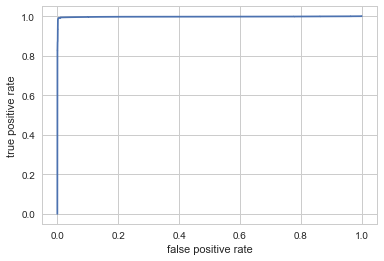

In [38]:
### ROC CURVE

decision_function = lr.decision_function(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, decision_function)
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

auc = roc_auc_score(y_test, lr.decision_function(X_test))
print("Area under curve for test is:",  auc)

In [39]:
auc = roc_auc_score(y_test, lr.decision_function(X_test))
auc

0.99743557368248814

#### Testing on validation file

In [40]:
Validation_features = test_data[num_features[:-1]].values
Validation_labels = test_data[num_features[-1]].values

In [41]:
print("R^2 on testing set: %f" % lr.score(Validation_features, Validation_labels))

R^2 on testing set: 0.844085


Area under curve for Validation set is: 0.948527118564


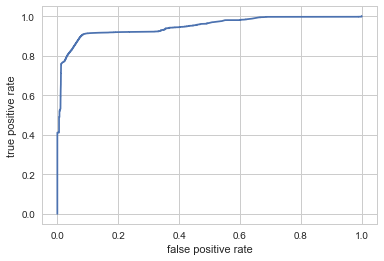

In [42]:
decision_function = lr.decision_function(Validation_features)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Validation_labels, decision_function)
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

auc = roc_auc_score(Validation_labels, lr.decision_function(Validation_features))
print("Area under curve for Validation set is:",  auc)

#### Decision Tree

In [84]:
train_features = train_data[num_features[:-1]].values
train_labels = train_data[num_features[-1]].values

print(train_features.shape)
print(train_labels.shape)

(4898431, 39)
(4898431,)


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.40, random_state=42)

print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)

(2939058, 39)
(1959373, 39)
(2939058,)
(1959373,)


In [86]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
print('Training Score',dt.score(X_train, y_train))
print('testing Score',dt.score(X_test, y_test))

Training Score 0.997589363667
testing Score 0.99755483004


In [87]:
feature_imp = pd.Series(dt.feature_importances_)
len(feature_imp)

39

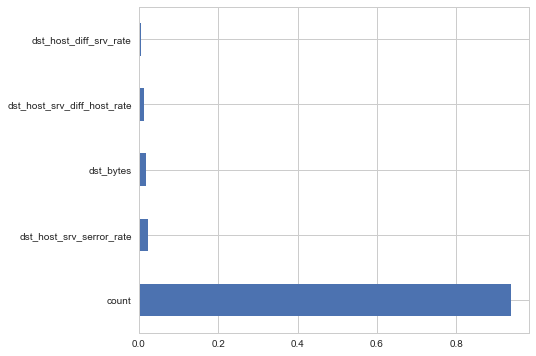

In [125]:
feature_importances = pd.Series(dt.feature_importances_, index=num_features[:-1])
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances[:5].plot(kind="barh", figsize=(7,6));


In [141]:
fpr, tpr, _ = roc_curve(Validation_labels, dt.predict_proba(Validation_features)[:,1])

In [143]:
tpr

array([  0.00000000e+00,   5.47045952e-04,   8.91569103e-01,
         8.96037311e-01,   8.96788002e-01,   8.98317335e-01,
         8.98544938e-01,   8.99020109e-01,   9.03324602e-01,
         9.03332588e-01,   9.03492309e-01,   9.99876216e-01,
         9.99904167e-01,   1.00000000e+00])

ROC AUC: 0.95


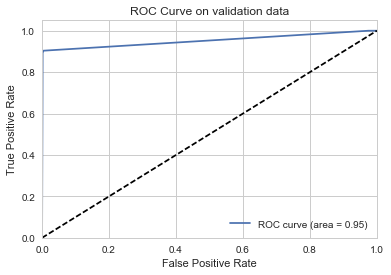

In [149]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(Validation_labels, dt.predict_proba(Validation_features)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on validation data')
plt.legend(loc="lower right")
plt.show()

In [98]:
from sklearn.metrics import classification_report

y_pred = dt.predict(Validation_features)
print(classification_report(Validation_labels, y_pred, target_names=["Attack", "Normal"]))

             precision    recall  f1-score   support

     Attack       0.71      1.00      0.83     60593
     Normal       1.00      0.90      0.95    250436

avg / total       0.94      0.92      0.93    311029



In [90]:
from sklearn.tree import  export_graphviz

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
%matplotlib inline
visualize_tree(dt, num_features[:-1])

#### Random Forest

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search

C:\Users\ajay\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ajay\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [103]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
parameters = {'max_features':['sqrt', 'log2'],
              'max_depth':[3, 4, 5]}

clf_grid = grid_search.GridSearchCV(rf, parameters)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [104]:
clf_grid.score(X_test, y_test)

0.99902468799968158

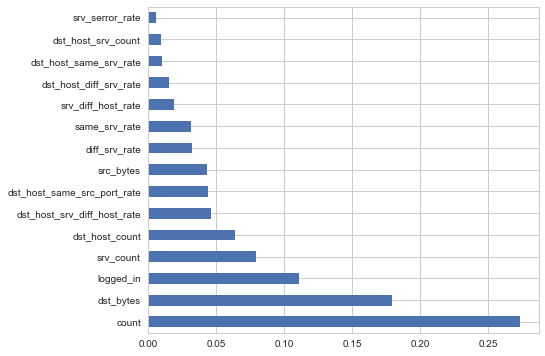

In [123]:
feature_importances = pd.Series(clf_grid.best_estimator_.feature_importances_, index=num_features[:-1])
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances[:15].plot(kind="barh", figsize=(7,6));


In [137]:
y_true = Validation_labels
y_score = dt.predict(Validation_features)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

Receiver operating characteristic - Area Under Curve: 0.98


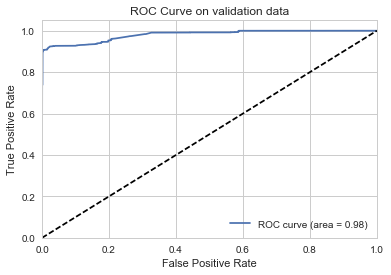

In [150]:
# dont forget to import roc_curve and auc funcitons

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(Validation_labels, clf_grid.best_estimator_.predict_proba(Validation_features)[:,1])

roc_auc = auc(fpr, tpr)
print('Receiver operating characteristic - Area Under Curve: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on validation data')
plt.legend(loc="lower right")
plt.show()